In [1]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from scipy import sparse 
import sys
from gaussiandata import SyntheticTarget
from onlinePrototypes import protonline
from onlineCriticism import crionline
#import greedy_functions
import math
import scipy
import matplotlib.pyplot as plt 
%matplotlib inline
import onlineGreedyfile

(1000, 2) => 100


In [2]:
SEED = 666
number_of_gaussians = 5
ex = SyntheticTarget(seed=SEED, dist_components=number_of_gaussians)

N = 10000
M = 30
data = ex.draw_sample(N)
print  data.size
print data[(2,3,4),:]
gamma = 2

20000
[[ 2.57290838 -1.57027672]
 [ 1.54036534 -1.39128911]
 [-3.9098723  -3.1189703 ]]


In [3]:
result = onlineGreedyfile.onlineGreedy(gamma, M, data, N)

[6267 7142 7602 7789 8251 8464 8665 8894 9252 9267 9374 9528 9547 9585 9659
 9668 9669 9716 9718 9720 9744 9758 9885 9919 9934 9957 9967 9975 9994 9998]


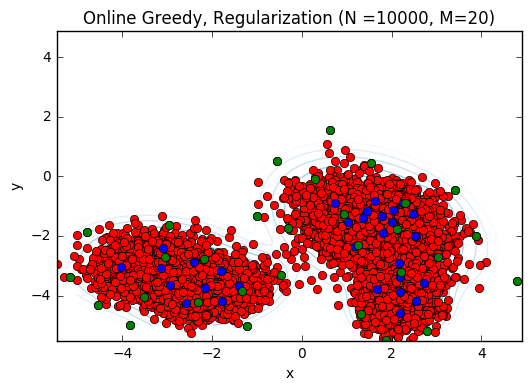

In [4]:
print result[0]
ex.plot()
plt.plot(data[:N,0], data[:N,1], 'ro');
plt.plot(data[result[0],0], data[result[0],1], 'bo');
plt.plot(data[result[1],0], data[result[1],1], 'go');
plt.xlabel('x')
plt.ylabel('y')
plt.title('Online Greedy, Regularization (N =10000, M=20)')
#plt.axis([-3, 6, -6, -1])